In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cuda = torch.cuda.is_available()
print(cuda)

False


In [10]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"/Users/rasmusjensen/Documents/02466-Cell-Profiling/data_subset")

batch_size = 64
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



7774 77 24 19


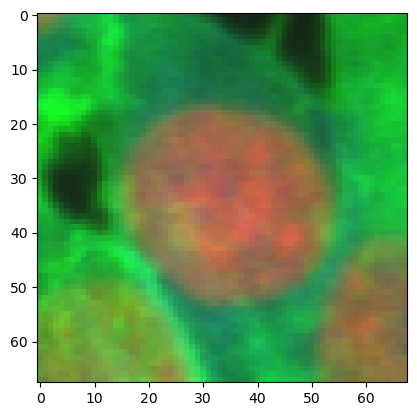

In [11]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [14]:
data = []
labels = []
for i in range(len(dataset)):
    data.append(dataset[i][0].numpy().flatten())
    labels.append(dataset[i][1])

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# train the model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.8392282958199357
